# Путешествие по Спрингфилду (Kaggle соревнование).


Задача состоит в том, чтобы научиться классифицировать персонажей, проживающих в Спрингфилде.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### 1. Установка зависимостей.

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from itertools import chain

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.version)
print("Torchvision Version: ", torchvision.version)


train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device('cpu')
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device('cuda')

PyTorch Version:  <module 'torch.version' from '/usr/local/lib/python3.6/dist-packages/torch/version.py'>
Torchvision Version:  <module 'torchvision.version' from '/usr/local/lib/python3.6/dist-packages/torchvision/version.py'>
CUDA is available!  Training on GPU ...


### 2. Загрузка данных.

In [68]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

Проверим, сколько фотографий есть в каждом из классов:

Подготовим обучающую и тестовые выборки. Обучающую выборку разделим на обущающую и валидационную выборки.

In [69]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [70]:
class_sample_counts = {}
for label in np.unique(train_val_labels).tolist():
  class_sample_counts.update({label:train_val_labels.count(label)})
print(class_sample_counts)

{'abraham_grampa_simpson': 913, 'agnes_skinner': 42, 'apu_nahasapeemapetilon': 623, 'barney_gumble': 106, 'bart_simpson': 1342, 'carl_carlson': 98, 'charles_montgomery_burns': 1193, 'chief_wiggum': 986, 'cletus_spuckler': 47, 'comic_book_guy': 469, 'disco_stu': 8, 'edna_krabappel': 457, 'fat_tony': 27, 'gil': 27, 'groundskeeper_willie': 121, 'homer_simpson': 2246, 'kent_brockman': 498, 'krusty_the_clown': 1206, 'lenny_leonard': 310, 'lionel_hutz': 3, 'lisa_simpson': 1354, 'maggie_simpson': 128, 'marge_simpson': 1291, 'martin_prince': 71, 'mayor_quimby': 246, 'milhouse_van_houten': 1079, 'miss_hoover': 17, 'moe_szyslak': 1452, 'ned_flanders': 1454, 'nelson_muntz': 358, 'otto_mann': 32, 'patty_bouvier': 72, 'principal_skinner': 1194, 'professor_john_frink': 65, 'rainier_wolfcastle': 45, 'ralph_wiggum': 89, 'selma_bouvier': 103, 'sideshow_bob': 877, 'sideshow_mel': 40, 'snake_jailbird': 55, 'troy_mcclure': 8, 'waylon_smithers': 181}


Отсюда мы видим, что классы достаточно несбалансированны. Для балансировки классов мы будем использовать Oversampling, чтобы малочисленные классы появлялись чаще, а многочисленные - реже.

In [71]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files] 

In [72]:
simpsons_dataset = {}
for label in np.unique(train_labels).tolist():
  simpsons_dataset[label] = []
for path, label in zip(train_files, train_labels):
  simpsons_dataset[label].append(path)
print(simpsons_dataset)

{'abraham_grampa_simpson': [PosixPath('train/dataset/abraham_grampa_simpson/pic_0494.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0761.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0020.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0656.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0386.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0357.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0872.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0274.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0718.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0826.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0623.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0484.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0817.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0267.jpg'), PosixPath('train/dataset/abraham_grampa_simpson/pic_0091.jpg'), PosixPath('t

In [73]:
# Дополним картинки классов у которых менее 300 картинок, до 300 картинок в классе
for person in simpsons_dataset:
    if len(simpsons_dataset[person]) < 300:
        simpsons_dataset[person] = simpsons_dataset[person] * (300 // len(simpsons_dataset[person]))
        simpsons_dataset[person].extend(simpsons_dataset[person][:300 - len(simpsons_dataset[person])])

In [74]:
new_train_files = []
for person in simpsons_dataset:
    new_train_files.extend(simpsons_dataset[person])
new_train_labels = [path.parent.name for path in new_train_files]

In [75]:
class_sample_counts = {}
for label in np.unique(new_train_labels).tolist():
  class_sample_counts.update({label:new_train_labels.count(label)})
print(class_sample_counts)

{'abraham_grampa_simpson': 685, 'agnes_skinner': 300, 'apu_nahasapeemapetilon': 467, 'barney_gumble': 300, 'bart_simpson': 1006, 'carl_carlson': 300, 'charles_montgomery_burns': 895, 'chief_wiggum': 739, 'cletus_spuckler': 300, 'comic_book_guy': 352, 'disco_stu': 300, 'edna_krabappel': 343, 'fat_tony': 300, 'gil': 300, 'groundskeeper_willie': 300, 'homer_simpson': 1684, 'kent_brockman': 373, 'krusty_the_clown': 904, 'lenny_leonard': 300, 'lionel_hutz': 300, 'lisa_simpson': 1015, 'maggie_simpson': 300, 'marge_simpson': 968, 'martin_prince': 300, 'mayor_quimby': 300, 'milhouse_van_houten': 809, 'miss_hoover': 300, 'moe_szyslak': 1089, 'ned_flanders': 1090, 'nelson_muntz': 300, 'otto_mann': 300, 'patty_bouvier': 300, 'principal_skinner': 895, 'professor_john_frink': 300, 'rainier_wolfcastle': 300, 'ralph_wiggum': 300, 'selma_bouvier': 300, 'sideshow_bob': 658, 'sideshow_mel': 300, 'snake_jailbird': 300, 'troy_mcclure': 300, 'waylon_smithers': 300}


Создадим класс SimpsonsDataset для более удобного использования изображений, в котором будет производиться изменение размера изображений, нормировка, преобразование в тензор и аугментации (случайное отражение по вертикали, поворот изображения на +- 15 градусов) обучающей выборки.

Полезные ссылки:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

https://pytorch.org/docs/stable/torchvision/transforms.html

In [76]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224 # rescale будет производиться, так как размеры изображений разные вследствие получения их из видеофайлов

class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files) # список файлов для загрузки
        self.mode = mode # режим работы

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self): # returns the size of the dataset
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index): # returns the ith datapoint
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)), # здесь мы приводим все изображения к одинаковому размеру
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_val_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
          x = transform_val_test(x)
          return x
        else:
          x = transform_val_test(x) if self.mode == 'val' else transform_train(x)
          label = self.labels[index]
          label_id = self.label_encoder.transform([label])
          y = label_id.item()
          return x, y

Подготовим Datasets:

In [77]:
train_dataset = SimpsonsDataset(new_train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')
all_dataset = SimpsonsDataset(new_train_files + val_files, mode = 'train')

Подготовим Dataloaders:

In [78]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
all_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=True)

Визуализируем аугментированную обучающую выборку, чтобы проверить адекватность аугментаций:

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
print(len(new_train_files))

21472


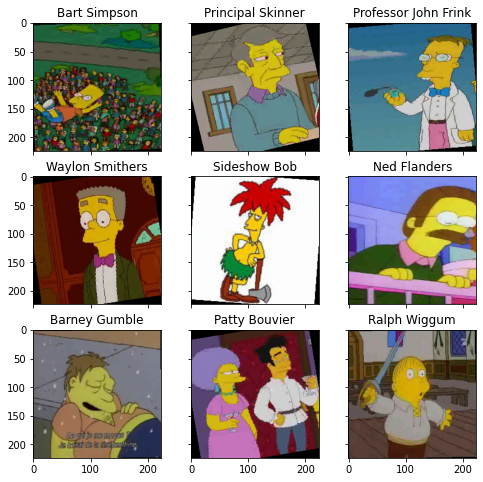

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,21472))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### 3.1. Модель AlexNet. Transfer learning. Смешанный метод.

In [ ]:
# Выберем базовую модель и применим к ней смешанный метод Transfer Learning
model_mixed = models.alexnet(pretrained=True) # по умолчанию сеть будет обучаться заново
print(model_mixed)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


Мы будем дообучать последние 5 слоев модели:

In [ ]:
layers_to_unfreeze = 5

Выключаем подсчет градиента для слоев, которые не будем обучать:

In [ ]:
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
  param.requires_grad = False

У предобученной сети на выходе 1000 нейронов, так как она обучалась на датасете ImageNet. Заменим последний слой для того, чтобы сделать классификацию изображений на num_classes классов:

In [ ]:
num_features = model_mixed.classifier[6].in_features
num_classes = len(np.unique(train_labels))
print(num_classes)

42


In [ ]:
model_mixed.classifier[6] = nn.Linear(num_features, num_classes)

In [ ]:
model_mixed = model_mixed.to(DEVICE)

Определим основные параметры обучения:

In [ ]:
EPOCHS = 30
criterion = nn.CrossEntropyLoss()
# Изменим lr для разных частей сети:
optimizer = optim.Adam(({'params':model_mixed.features.parameters(), 'lr':1e-6,}, {'params':model_mixed.classifier.parameters(),}), lr=1e-4)

### 3.1.1. Обучение.

Подготовим train and test loops.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    correct = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        correct += torch.eq(preds, labels).sum().item()
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = 100 * (running_corrects.cpu().numpy() / processed_data)
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = 100 * (running_corrects.double() / processed_size)
    return val_loss, val_acc

In [ ]:
def train(train_loader, val_loader, model, optimizer, criterion, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            state = {'net': model.state_dict(),
                     'acc': train_acc,
                     'epoch': epoch,}
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt_{}.pth'.format('alexnet'))
    return history

In [ ]:
history = train(train_loader, val_loader, model=model_mixed, optimizer=optimizer, criterion=criterion, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   3%|▎         | 1/30 [04:46<2:18:39, 286.87s/it]


Epoch 001 train_loss: 1.8727     val_loss 1.0293 train_acc 50.4797 val_acc 71.7616


epoch:   7%|▋         | 2/30 [09:30<2:13:27, 285.99s/it]


Epoch 002 train_loss: 0.6239     val_loss 0.7380 train_acc 82.8521 val_acc 79.8242


epoch:  10%|█         | 3/30 [14:14<2:08:23, 285.33s/it]


Epoch 003 train_loss: 0.3381     val_loss 0.6582 train_acc 90.8113 val_acc 82.1742


epoch:  13%|█▎        | 4/30 [18:55<2:03:04, 284.01s/it]


Epoch 004 train_loss: 0.2146     val_loss 0.5973 train_acc 94.1692 val_acc 84.7153


epoch:  17%|█▋        | 5/30 [23:36<1:57:59, 283.18s/it]


Epoch 005 train_loss: 0.1330     val_loss 0.6727 train_acc 96.4512 val_acc 83.2060


epoch:  20%|██        | 6/30 [28:17<1:52:56, 282.37s/it]


Epoch 006 train_loss: 0.0857     val_loss 0.5986 train_acc 97.7273 val_acc 85.5942


epoch:  23%|██▎       | 7/30 [32:57<1:48:01, 281.78s/it]


Epoch 007 train_loss: 0.0652     val_loss 0.5865 train_acc 98.2489 val_acc 85.9381


epoch:  27%|██▋       | 8/30 [37:38<1:43:15, 281.62s/it]


Epoch 008 train_loss: 0.0497     val_loss 0.6309 train_acc 98.7565 val_acc 85.8235


epoch:  30%|███       | 9/30 [42:19<1:38:30, 281.43s/it]


Epoch 009 train_loss: 0.0424     val_loss 0.5955 train_acc 98.9056 val_acc 86.6641


epoch:  33%|███▎      | 10/30 [47:00<1:33:41, 281.08s/it]


Epoch 010 train_loss: 0.0400     val_loss 0.6087 train_acc 98.9382 val_acc 86.0527


epoch:  37%|███▋      | 11/30 [51:41<1:29:03, 281.21s/it]


Epoch 011 train_loss: 0.0312     val_loss 0.5957 train_acc 99.3294 val_acc 86.3775


epoch:  40%|████      | 12/30 [56:22<1:24:21, 281.18s/it]


Epoch 012 train_loss: 0.0278     val_loss 0.6088 train_acc 99.2455 val_acc 86.5113


epoch:  43%|████▎     | 13/30 [1:01:03<1:19:39, 281.14s/it]


Epoch 013 train_loss: 0.0236     val_loss 0.6176 train_acc 99.3946 val_acc 87.0271


epoch:  47%|████▋     | 14/30 [1:05:45<1:14:59, 281.21s/it]


Epoch 014 train_loss: 0.0272     val_loss 0.6749 train_acc 99.2595 val_acc 85.7279


epoch:  50%|█████     | 15/30 [1:10:27<1:10:24, 281.64s/it]


Epoch 015 train_loss: 0.0249     val_loss 0.6008 train_acc 99.3014 val_acc 87.5430


epoch:  53%|█████▎    | 16/30 [1:15:10<1:05:47, 282.00s/it]


Epoch 016 train_loss: 0.0217     val_loss 0.6246 train_acc 99.5156 val_acc 86.9507


epoch:  57%|█████▋    | 17/30 [1:19:51<1:01:02, 281.70s/it]


Epoch 017 train_loss: 0.0185     val_loss 0.6282 train_acc 99.5017 val_acc 86.9507


epoch:  60%|██████    | 18/30 [1:24:30<56:10, 280.86s/it]


Epoch 018 train_loss: 0.0238     val_loss 0.6062 train_acc 99.3713 val_acc 87.5239


epoch:  63%|██████▎   | 19/30 [1:29:09<51:24, 280.40s/it]


Epoch 019 train_loss: 0.0215     val_loss 0.6727 train_acc 99.3852 val_acc 86.2629


epoch:  67%|██████▋   | 20/30 [1:33:50<46:43, 280.34s/it]


Epoch 020 train_loss: 0.0179     val_loss 0.6416 train_acc 99.5389 val_acc 87.2946


epoch:  70%|███████   | 21/30 [1:38:31<42:05, 280.64s/it]


Epoch 021 train_loss: 0.0177     val_loss 0.6230 train_acc 99.4877 val_acc 87.8678


epoch:  73%|███████▎  | 22/30 [1:43:10<37:22, 280.27s/it]


Epoch 022 train_loss: 0.0213     val_loss 0.6852 train_acc 99.3946 val_acc 87.2564


epoch:  77%|███████▋  | 23/30 [1:47:49<32:39, 279.87s/it]


Epoch 023 train_loss: 0.0167     val_loss 0.6657 train_acc 99.4970 val_acc 87.4092


epoch:  80%|████████  | 24/30 [1:52:30<28:00, 280.07s/it]


Epoch 024 train_loss: 0.0156     val_loss 0.6961 train_acc 99.5762 val_acc 87.0462


epoch:  83%|████████▎ | 25/30 [1:57:10<23:20, 280.14s/it]


Epoch 025 train_loss: 0.0152     val_loss 0.6485 train_acc 99.5948 val_acc 87.9060


epoch:  87%|████████▋ | 26/30 [2:01:51<18:41, 280.40s/it]


Epoch 026 train_loss: 0.0195     val_loss 0.6597 train_acc 99.4178 val_acc 87.3710


epoch:  90%|█████████ | 27/30 [2:06:31<14:00, 280.28s/it]


Epoch 027 train_loss: 0.0153     val_loss 0.7128 train_acc 99.5343 val_acc 86.7596


epoch:  93%|█████████▎| 28/30 [2:11:13<09:21, 280.61s/it]


Epoch 028 train_loss: 0.0201     val_loss 0.6769 train_acc 99.4504 val_acc 87.3328


epoch:  97%|█████████▋| 29/30 [2:15:53<04:40, 280.49s/it]


Epoch 029 train_loss: 0.0162     val_loss 0.7324 train_acc 99.4924 val_acc 86.2056


epoch: 100%|██████████| 30/30 [2:20:34<00:00, 280.64s/it]


Epoch 030 train_loss: 0.0177     val_loss 0.7154 train_acc 99.4504 val_acc 87.1800


epoch: 100%|██████████| 30/30 [2:20:34<00:00, 281.16s/it]


Построим кривые обучения:

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

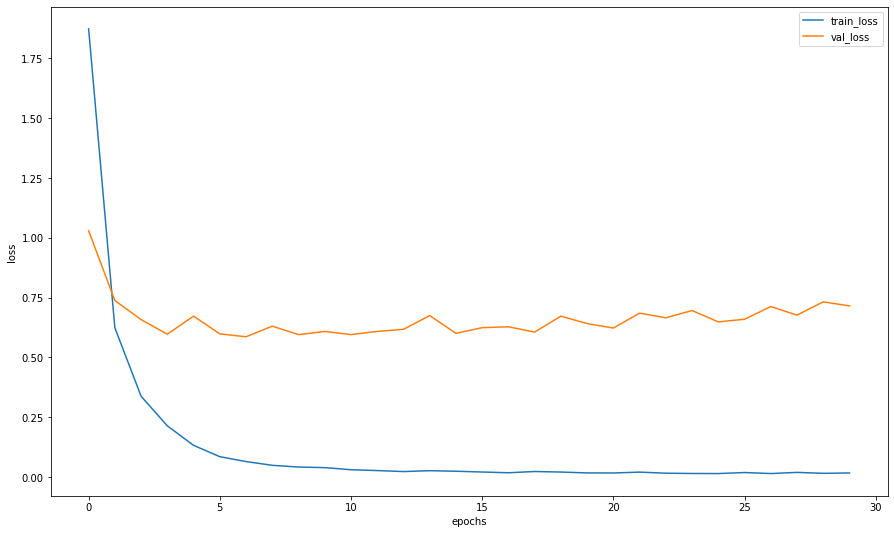

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Результат на Kaggle: 0.94261. Нас не устраивает такой результат, поэтому будем использовать более сложную модель.

### 3.2. Модель Resnet18. Transfer learning. Смешанный метод.

Выберем модель Resnet18, так как она лучше модели AlexNet по качеству, но ее время обучения такое же невысокое при меньшем весе сети:

![picture](https://drive.google.com/uc?id=1yOo1pLohpvk4eDHZcbHaSgPB1blnA8ii)

In [83]:
model_resnet18 = models.resnet18(pretrained=True) # по умолчанию сеть будет обучаться заново, если не заморозить веса
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

У предобученной сети на выходе 1000 нейронов, так как она обучалась на датасете ImageNet. Заменим последний слой для того, чтобы сделать классификацию изображений на num_classes классов:

In [84]:
num_features = model_resnet18.fc.in_features
num_classes = len(np.unique(train_labels))
print(num_features)
print(num_classes)

512
42


In [85]:
model_resnet18.fc = nn.Linear(num_features, num_classes)

Заморозим первый слой модели в соответствии с данной рекомендацией, так как у нас маленький датасет, который отличается от изображений, на которых была предобучена модель:

![picture](https://drive.google.com/uc?id=1_OdbhUqNPx-PDCMik5wzR1Tf5icFSpFH)



Заморозка первого слоя позволит нам использовать модель, базовые паттерны которой уже натренированы на датасете ImageNet, а на специфические паттерны, которые присущи только нашему датасету, мы будем обучаться в последующих размороженных слоях.

In [86]:
child_number = 0
for child in model_resnet18.children():
  child_number += 1
  if child_number > 5:
    print(child)
    for param in child.parameters():
        param.requires_grad = True
  else:
    for param in child.parameters():
        param.requires_grad = False

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-

In [87]:
model_resnet18 = model_resnet18.to(DEVICE)

Определим основные параметры обучения нейросети:

In [88]:
EPOCHS = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

### 3.2.1. Обучение.

Подготовим train and test loops.

In [33]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    correct = 0
    f1 = 0
    y_pred_list = []
    y_true_list = []
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        correct += torch.eq(preds, labels).sum().item()
        processed_data += inputs.size(0)

        y_pred_list.append(preds.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())
    
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    report_dict = classification_report(y_true_list, y_pred_list, output_dict=True)
    for key, value in report_dict.items():
      if isinstance(value, dict):
        f1 += value['f1-score']

    train_loss = running_loss / processed_data
    train_acc = 100 * (running_corrects.cpu().numpy() / processed_data)
    f1_score = 100 * f1 / processed_data
    return train_loss, train_acc, f1_score

In [34]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    f1 = 0
    y_pred_list = []
    y_true_list = []
 
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        y_pred_list.append(preds.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    report_dict = classification_report(y_true_list, y_pred_list, output_dict=True)
    for key, value in report_dict.items():
      if isinstance(value, dict):
        f1 += value['f1-score']

    # print("Val classification report: ", classification_report(y_true_list, y_pred_list))
    val_loss = running_loss / processed_size
    val_acc = 100 * (running_corrects.double() / processed_size)
    f1_score = 100 * f1 / processed_size
    return val_loss, val_acc, f1_score

In [89]:
def train(train_loader, val_loader, model, optimizer, criterion, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            torch.cuda.empty_cache()
            train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))
            if epoch > 10:
              scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            state = {'net': model.state_dict(),
                     'acc': train_acc,
                     'epoch': epoch,}
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt_{}.pth'.format('resnet18'))
    return history

Обучим модель:

In [90]:
history_resnet18 = train(train_loader, val_loader, model=model_resnet18, optimizer=optimizer, criterion=criterion, epochs=EPOCHS, batch_size=BATCH_SIZE)

epoch:   7%|▋         | 1/15 [05:12<1:12:51, 312.27s/it]


Epoch 001 train_loss: 1.1877     val_loss 0.3386 train_acc 75.1118 val_acc 94.2874


epoch:  13%|█▎        | 2/15 [10:22<1:07:31, 311.68s/it]


Epoch 002 train_loss: 0.2231     val_loss 0.2266 train_acc 94.2018 val_acc 94.4211


epoch:  20%|██        | 3/15 [15:31<1:02:09, 310.79s/it]


Epoch 003 train_loss: 0.1186     val_loss 0.2050 train_acc 96.8051 val_acc 94.8414


epoch:  27%|██▋       | 4/15 [20:41<56:55, 310.49s/it]


Epoch 004 train_loss: 0.0727     val_loss 0.1852 train_acc 97.9927 val_acc 95.3764


epoch:  33%|███▎      | 5/15 [25:49<51:37, 309.73s/it]


Epoch 005 train_loss: 0.0496     val_loss 0.1807 train_acc 98.6541 val_acc 95.8922


epoch:  40%|████      | 6/15 [30:52<46:11, 307.91s/it]


Epoch 006 train_loss: 0.0409     val_loss 0.2096 train_acc 98.8404 val_acc 95.3573


epoch:  47%|████▋     | 7/15 [35:58<40:59, 307.38s/it]


Epoch 007 train_loss: 0.0400     val_loss 0.1730 train_acc 98.8497 val_acc 96.3126


epoch:  53%|█████▎    | 8/15 [41:03<35:45, 306.55s/it]


Epoch 008 train_loss: 0.0308     val_loss 0.1769 train_acc 99.1757 val_acc 96.3126


epoch:  60%|██████    | 9/15 [46:09<30:38, 306.47s/it]


Epoch 009 train_loss: 0.0275     val_loss 0.1674 train_acc 99.2083 val_acc 96.4845


epoch:  67%|██████▋   | 10/15 [51:15<25:31, 306.40s/it]


Epoch 010 train_loss: 0.0292     val_loss 0.1801 train_acc 99.1524 val_acc 96.5227


epoch:  73%|███████▎  | 11/15 [56:23<20:26, 306.64s/it]


Epoch 011 train_loss: 0.0216     val_loss 0.1902 train_acc 99.3154 val_acc 96.2553


epoch:  80%|████████  | 12/15 [1:01:29<15:20, 306.68s/it]


Epoch 012 train_loss: 0.0143     val_loss 0.2374 train_acc 99.5436 val_acc 95.0325


epoch:  87%|████████▋ | 13/15 [1:06:37<10:13, 306.82s/it]


Epoch 013 train_loss: 0.0234     val_loss 0.1731 train_acc 99.3061 val_acc 96.4463


epoch:  93%|█████████▎| 14/15 [1:11:43<05:06, 306.66s/it]


Epoch 014 train_loss: 0.0112     val_loss 0.1840 train_acc 99.6600 val_acc 96.9813


epoch: 100%|██████████| 15/15 [1:16:49<00:00, 307.30s/it]


Epoch 015 train_loss: 0.0104     val_loss 0.1952 train_acc 99.6880 val_acc 96.1979


Построим кривые обучения:

In [97]:
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*history_resnet18)

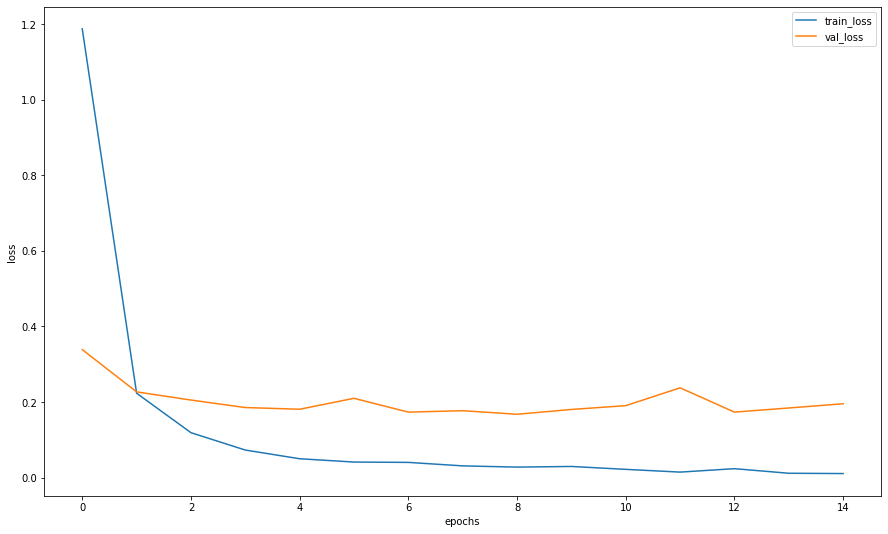

In [98]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Полученной точности на обучающей и валидационной выборках должно быть достаточно для получения точности 0.97 на тестовом датасете Kaggle. Проверим это.

### 5. Проверка на тестовых данных.

In [99]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for data in test_loader:
            data = data.to(DEVICE)
            model.eval()
            outputs = model(data).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [101]:
probs = predict(model_resnet18, test_loader)

In [102]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [103]:
my_submit = pd.read_csv("gdrive/My Drive/simpsons/sample_submission.csv")
print(my_submit)

             Id      Expected
0      img0.jpg  bart_simpson
1      img1.jpg  bart_simpson
2      img2.jpg  bart_simpson
3      img3.jpg  bart_simpson
4      img4.jpg  bart_simpson
..          ...           ...
986  img986.jpg  bart_simpson
987  img987.jpg  bart_simpson
988  img988.jpg  bart_simpson
989  img989.jpg  bart_simpson
990  img990.jpg  bart_simpson

[991 rows x 2 columns]


In [104]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit)

             Id                  Expected
0      img0.jpg              nelson_muntz
1      img1.jpg              bart_simpson
2     img10.jpg              ned_flanders
3    img100.jpg              chief_wiggum
4    img101.jpg    apu_nahasapeemapetilon
..          ...                       ...
986  img987.jpg              nelson_muntz
987  img988.jpg              ned_flanders
988  img989.jpg  charles_montgomery_burns
989   img99.jpg              chief_wiggum
990  img990.jpg          krusty_the_clown

[991 rows x 2 columns]


In [105]:
my_submit.to_csv('gdrive/My Drive/simpsons/my_submission.csv', index=False)

### 6. Kaggle.

Ссылка на leaderboard: https://www.kaggle.com/c/journey-springfield/leaderboard

Ник: Ksenia_Evteeva_35359106

Результат: 0.99149